In [1]:
# Estimate the position of the robot in 2D plane using particle filter
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import scipy


Store_Prop_Particles = []

Store_Resam_Particles = []

# Define the initial time
InitialTime = 0

# Define the number of particles
N = 1000

InitialParticles = np.full(shape=(N,3,3),fill_value=np.array([[1,0,0],[0,1,0],[0,0,1]]), dtype=float)

# Define the wheel speeds
WheelSpeeds = np.array([1.5,2])

# Define the target time
TargetTime = 20

# Define the intrinsic parameters
IntrinsicParameters = np.array([0.25,0.5])

# Define the noise parameters
NoiseParameters = np.array([0.05, 0.05, 0.1])

time = [5,10,15,20]

Measurements=np.array([[1.6561, 1.2847], [1.0505, 3.1059], [-0.9875, 3.2188], [-1.6450, 1.1978]])

# Particle Filter propagation step 
def ParticleFilterPredict(InitialTime, FinalTime, Particles, WheelSpeeds, IntrinsicParameters, NoiseParameters, N):

	PosteriorParticles = np.empty((0,3,3), dtype=float)

	for i in range(N):

		# Sample a left and right wheel speeds from the noisy wheel distributions
		LeftWheelSpeed = np.random.normal(WheelSpeeds[0], NoiseParameters[0])
		RightWheelSpeed = np.random.normal(WheelSpeeds[1], NoiseParameters[1])
	
		# Creating the Lie algebra element of SE(2)
		Lie01 = (-IntrinsicParameters[0]/IntrinsicParameters[1])*(RightWheelSpeed - LeftWheelSpeed)
		Lie10 = (IntrinsicParameters[0]/IntrinsicParameters[1])*(RightWheelSpeed - LeftWheelSpeed)
		Lie02 = (IntrinsicParameters[0]/2)*(RightWheelSpeed + LeftWheelSpeed)
		LieAlgebra = np.array([[0, Lie01, Lie02], [Lie10, 0, 0], [0,0,0]])
		
		# Propagation step using the exponential map and the prior particles
		NewParticle = Particles[i]@scipy.linalg.expm((FinalTime-InitialTime)*LieAlgebra)
	
		PosteriorParticles = np.vstack((PosteriorParticles, [NewParticle]))

	return PosteriorParticles

# Particle Filter update step implementation
def ParticleFilterUpdate(Particles, NoiseParameters, N, Measures):

	Weights = np.zeros((N,1))
	
	# calculating the weight based on the likelihood funtction
	for i in range(N):
		Weights[i] = stats.multivariate_normal.pdf(Measures, mean=[Particles[i,0,2], Particles[i,1,2]], cov=np.diag([NoiseParameters[2]**2, NoiseParameters[2]**2]))
	
	ResampledParticles = np.empty((0,3,3), dtype=float)
	
	resamps = random.choices(Particles, weights=Weights, k=1000)
	
	for i in range(N):
		ResampledParticles = np.vstack((ResampledParticles, [resamps[i]]))

	return(ResampledParticles)

# Main function
if __name__ == '__main__':

	i = 0
	# Run the particle filter
	for FinalTime in time:
		Particles = ParticleFilterPredict(InitialTime, FinalTime, InitialParticles, WheelSpeeds, IntrinsicParameters, NoiseParameters, N)
		Store_Prop_Particles.append(Particles)
		ReParticles = ParticleFilterUpdate(Particles, NoiseParameters, N, Measurements[i])
		Store_Resam_Particles.append(ReParticles)
		InitialTime = FinalTime
		InitialParticles = ReParticles
		i += 1

at 10 : mean [1.1031812 3.0716259] Co-variance: [[0.42800223 0.03770982]
 [0.03770982 0.0200635 ]]


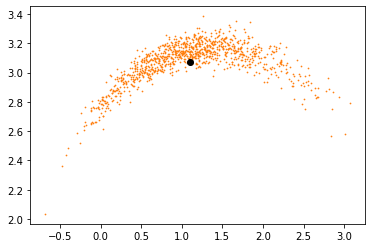

In [2]:
# Gnerating 1000 realizations of the propagation step

FinalTime = 10

# Define the number of particles
N = 1000

InitialParticles = np.full(shape=(N,3,3),fill_value=np.array([[1,0,0],[0,1,0],[0,0,1]]), dtype=float)

InitialTime = 0

Particles = ParticleFilterPredict(InitialTime, FinalTime, InitialParticles, WheelSpeeds, IntrinsicParameters, NoiseParameters, N)
		
X = Particles[:,0,2]
X = np.reshape(X, (1000,1))
Y = Particles[:,1,2]
Y = np.reshape(Y, (1000,1))
Z = np.concatenate((X, Y), axis=1)
mean = np.mean(Z, axis=0)
X_mean = mean[0]
Y_mean = mean[1]
print('at 10', ':', 'mean', mean, 'Co-variance:', np.cov(Z.T))
plt.scatter(InitialParticles[:,0,2], InitialParticles[:,1,2])
plt.scatter(Particles[:,0,2], Particles[:,1,2], s=0.5)
plt.scatter(X_mean, Y_mean, c='black')

at 5 : mean [1.65105895 1.18791427] Co-variance: [[ 0.0213563  -0.01665163]
 [-0.01665163  0.01600216]]
at 10 : mean [1.05643175 3.10363137] Co-variance: [[0.26152033 0.0048751 ]
 [0.0048751  0.01397751]]
at 15 : mean [-0.91841795  3.15295255] Co-variance: [[0.28623017 0.22008746]
 [0.22008746 0.32910955]]
at 20 : mean [-1.57348215  1.32061777] Co-variance: [[ 0.23631098 -0.10637659]
 [-0.10637659  0.59344406]]


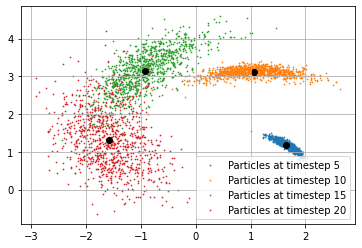

In [3]:
# Particle filter propogation for 5, 10, 15 and 20 timesteps

time = [5, 10, 15, 20]

# Define the number of particles
N = 1000

InitialParticles = np.full(shape=(N,3,3),fill_value=np.array([[1,0,0],[0,1,0],[0,0,1]]), dtype=float)

InitialTime = 0

for FinalTime in time:
    Particles = ParticleFilterPredict(InitialTime, FinalTime, InitialParticles, WheelSpeeds, IntrinsicParameters, NoiseParameters, N)
    plt.scatter(Particles[:,0,2], Particles[:,1,2], s=0.5, label="Particles at timestep {}".format(FinalTime))
    X = Particles[:,0,2]
    X = np.reshape(X, (1000,1))
    Y = Particles[:,1,2]
    Y = np.reshape(Y, (1000,1))
    Z = np.concatenate((X, Y), axis=1)
    mean = np.mean(Z, axis=0)
    X_mean = mean[0]
    Y_mean = mean[1]
    print('at', FinalTime, ':', 'mean', mean, 'Co-variance:', np.cov(Z.T))
    InitialTime = FinalTime
    InitialParticles = Particles
    plt.scatter(X_mean, Y_mean, c='black')

plt.legend()
plt.grid(visible=True)
plt.show()

at 5 : mean [1.6317598  1.23265051] Co-variance: [[ 0.00486129 -0.00285666]
 [-0.00285666  0.00366863]]
at 10 : mean [1.03527147 3.14390667] Co-variance: [[0.00879607 0.00111605]
 [0.00111605 0.00471108]]
at 15 : mean [-0.99390464  3.21496804] Co-variance: [[0.00595136 0.00023972]
 [0.00023972 0.00910448]]
at 20 : mean [-1.63520251  1.22984352] Co-variance: [[ 0.00870936 -0.00089604]
 [-0.00089604  0.0048677 ]]


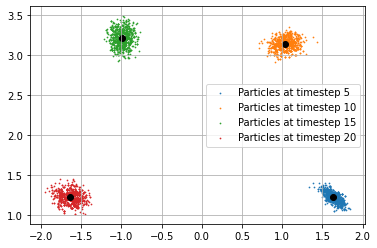

In [4]:
# Particle filter update for 5, 10, 15 and 20 timesteps
i = [5, 10, 15, 20]

j = 0
for Posterior in Store_Resam_Particles:
  X = Posterior[:,0,2]
  X = np.reshape(X, (1000,1))
  Y = Posterior[:,1,2]
  Y = np.reshape(Y, (1000,1))
  Z = np.concatenate((X, Y), axis=1)
  mean = np.mean(Z, axis=0)
  X_mean = mean[0]
  Y_mean = mean[1]
  print('at', i[j], ':', 'mean', mean, 'Co-variance:', np.cov(Z.T))
  plt.scatter(Posterior[:,0,2], Posterior[:,1,2], s=0.5, label="Particles at timestep {}".format(i[j]))
  plt.scatter(X_mean, Y_mean, c='black')
  j += 1

plt.legend()
plt.grid(visible=True)
plt.show()